## Tutorial 2: Choosing a normalizing flow architecture.

Here, we will run the same EPI optimization as in Tutorial 1, but with different normalizing flow architectures.  The normalizing flow is the deep generative model (model of the distribution *not* the neural circuit model) chosen to approximate the distribution.  This tutorial should give an idea of what architectures are suitable for a given EPI distribution, and how to design a architecture search.

Throughout the tutorial, please refer to the API documentation at [https://epi.readthedocs.io/en/latest/API.html](https://epi.readthedocs.io/en/latest/API.html).

First, we'll run the setup code from Tutorial 1 right up until we invoke the EPI method.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# Mac OS jupyter kernel dies without.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from epi.models import Model, Parameter
import time

# 1. Define the model.
lb, ub = -10., 10.
a11 = Parameter("a11", 1, lb=lb, ub=ub)
a12 = Parameter("a12", 1, lb=lb, ub=ub)
a21 = Parameter("a21", 1, lb=lb, ub=ub)
a22 = Parameter("a22", 1, lb=lb, ub=ub)
name = "lds_2D"
params = [a11, a12, a21, a22]
M = Model(name, params)

# 2. Define the emergent property.
def linear2D_eig(a11, a12, a21, a22):
    tau = 1.0
    c11 = a11 / tau
    c12 = a12 / tau
    c21 = a21 / tau
    c22 = a22 / tau

    
    # Quadratic formula.
    real_term = 0.5 * (c11 + c22)
    complex_term = 0.5 * tf.sqrt(
        tf.complex(tf.square(c11 + c22) - 4.0 * (c11 * c22 - c12 * c21), 0.0)
    )
    real_lambda = real_term + tf.math.real(complex_term)
    imag_lambda = tf.math.imag(complex_term)

    T_x = tf.concat(
        (
            real_lambda,
            imag_lambda,
            tf.square(real_lambda - 0.),
            tf.square(imag_lambda - (2. * np.pi)),
        ),
        axis=1,
    )
    return T_x
M.set_eps(linear2D_eig)

# 3. Run emergent property inference.
mu = np.array([0.0, 2 * np.pi, 0.5**2, (0.2 * np.pi)**2])

#### What are normalizing flows?

Normalizing flows model complex distributions as a transformation of a simple base density by an invertible function.  This base density is usually an isotropic gaussian, as is common in deep generative modeling, or maybe a uniform or other distribution.  Normalizing flows are often described as a sequence of invertible, differentiable transformations $f : \mathcal{R}^D \rightarrow \mathcal{R}^D$ of such a base density:
$$\omega \sim q_0(\omega)$$
$$z_K = f_K \circ ... \circ f_2 \circ f_1(\omega)$$.

Why is the invertibility of each $f$ so critical?  The key property of normalizing flows is that they facilitate an efficient calculation of sample density.  Unlike ordinary deep generative models like variational autoencoder (VAE) decoders and generative adversarial networks (GANs), normalizing flows provide samples _and_ sample density in one forward pass of the network.  This sample density calculation relies on the change of variables formula, which is only valid for invertible transforms $f$.  Specifically, the density of a variable $z' = f(z)$ is
$$ q(z') = q(f^{-1}(z')) \left| \det \frac{\partial f^{-1}(z')}{\partial z'} \right| = q(z) \left| \det \frac{\partial f(z)}{\partial z} \right|^{-1}$$

Normalizing flows are thusly named because they _normalize_ the probability density of their samples as they step through each stage of the generative process (the _flow_).  The key to an effective normalizing flow is that the determinant jacobian (or log determinant jacobian) terms are fast making optimization with respect to sample log density tractable.  Fully-connected bijective neural network layers have $O(D^3)$ (very slow) log determinant jacobians, so they are not considered to be normalizing flows despite their invertibility.  Normalizing flows research is focused on the  design of function families that are expressive, yet have tractable (roughly $O(D)$) log determinant jacobian terms.

I highly recommend Papamakarios et al. 2019, which is a great recent review on normalizing flows.
[https://arxiv.org/abs/1912.02762](https://arxiv.org/abs/1912.02762)

#### Why EPI needs normalizing flows.

EPI has a maximum entropy objective:

$$\underset{q_\theta \in Q}{\mathrm{arg max}} \hspace{.2cm} H(q_\theta(z))$$

$$\text{s.t.} \mathbb{E}_{z \sim q_\theta}[ \mathbb{E}_{x \sim p(x \mid z)}[T(x)]] = \mu.$$

We can obtain gradients of the entropy in terms of the average batch gradient of the sample log density using the reparameterization trick.
$$\nabla_\theta H(q_\theta) = \nabla_\theta \mathbb{E}_{z \sim q_\theta}[-\log q_\theta(z)] = - \mathbb{E}_{\omega \sim q_0}[\nabla_\theta  \log q_\theta(f_\theta(\omega))]$$

Arbitrary bijective deep generative models containing fully-connected neural network layers will have $O(D^3)$ log determinant jacobians in the calculation of $\nabla_\theta  \log q_\theta(f_\theta(\omega))$.  We reduce this to $O(D)$ to make optimization tractable using a normalizing flow for $f_\theta$.

#### Specifying normalizing flow architectures for EPI using the optional parameters of  `Model.epi` .

There are several optional parameters to the [`epi.models.Model.epi`](https://epi.readthedocs.io/en/latest/API.html#epi.models.Model.epi) method that can be used to specify a particular normalizing flow:

(Please reference Papamakarios et al. 2019 [https://arxiv.org/abs/1912.02762](https://arxiv.org/abs/1912.02762) for clarification on terminology like "transform" and "conditioner".

* `arch_type (str)` - specifies if the normalizing flow architecture has either "coupling" or "autoregressive" stages.  Coupling stages are implemented via Real NVP  [https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/RealNVP](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/RealNVP), and autoregressive stages are implemented via MAF [
https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow).  All normalizing flows employ the affine transform.
* `num_stages (int)` - specifies the number of stages in the architecture.  For coupling flows, each stage is defined as a single Real NVP, where half of the dimensions are conditioned on the other half.  In autoregressive flows, each stage is defined as a full autoregressive factorization.  In between each stage of the normalizing flow, we permute the dimensions of the variable (as is standard practice) to vary the conditioning at each stage.
* `num_layers (int)` - specifies the number of fully connected neural network layers parameterizing the conditioners.
* `num_units (int)` - specifies the number of units per hidden layer of the condioners.
* `batch_norm (bool)` - True if batch normalization shall be used between stages (recommended).  The batch norm transform is accounted for in the log density calculation as with any other bijection in the flow.
* `bn_momentum (float)` - The momentum parameter of batch normalization.
* `post_affine (bool)` - True if final transform shall be a scale and shift of each dimension.
* `random_seed (int)` - Random seed of the normalizing flow initialization.

In Tutorial 1, we used the default normalzing flow architecture:
```python
q_theta, opt_data, save_path, flg = M.epi(
    mu, 
    c0=1e-3,
    stop_early=True,
    verbose=True,
    save_movie_data=True,
)
```
which corresponded to:
* `arch_type="coupling"`
* `num_stages=3` 
* `num_layers=2` 
* `num_units=max(2D, 15)`
* `batch_norm=True` 
* `bn_momentum=0.99`
* `post_affine=False`
* `random_seed=1`

### Experimenting with different normalizing flow architectures

Coupling architectures without enough stages of conditioning will not be expressive enough to represent the distributions they approximate.  We can see this with a coupling architecture having a single stage in 4 dimensions optimized to approximate the distribution of 2D LDS coefficients elaborated in Tutorial 1.  This architecture only optimizes the conditional distribution of $p(a_{21}, a_{22} \mid a_{11}, a_{12})$, compared to the other coupling architectures with multiple stages.

In [2]:
num_stages = [1, 2, 3]
q_theta_coups = []
opt_data_coups = []
timing_coups = []
q_theta_ars = []
opt_data_ars = []
timing_ars = []

for i in range(len(num_stages)):
    _num_stages = num_stages[i]
    # Run EPI with coupling flow.
    print('Running EPI with a coupling flow and %d stage(s).' % _num_stages)
    _time = time.time()
    q_theta, opt_data, _, _ = M.epi(
        mu,
        arch_type='coupling',
        num_stages=_num_stages,
        num_iters = 2500,
        c0=1e-3,
    )
    timing_coups.append(time.time() - _time)
    q_theta_coups.append(q_theta)
    opt_data_coups.append(opt_data)
    
# Run EPI with autoregressive flow.
print('Running EPI with a autoregressive flow and 1 stage.')
_time = time.time()
q_theta_ar, opt_data_ar, _, _ = M.epi(
    mu,
    arch_type='autoregressive',
    num_stages=1,
    num_iters = 1000,
    c0=1e-3,
)
timing_ar = time.time() - _time

Running EPI with a coupling flow and 1 stage(s).
Initializing D4_C1_L2_U15_rs1 architecture.
Loading variables from cached initialization.
Saving EPI models to data/lds_2D_linear2D_eig//D4_C1_L2_U15_rs1/.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
EPI(k= 0,i=   0): cost  1.78E+03, H  8.75E+00, |R|^2 1.79E+03
EPI(k= 1,i=2500): cost -1.11E+01, H  1.16E+01, |R|^2 1.01E+03
EPI(k= 2,i=2500): cost -9.58E+00, H  1.08E+01, |R|^2 3.30E+02
EPI(k= 3,i=2500): cost -7.70E+00, H  9.71E+00, |R|^2 1.13E+02
EPI(k= 4,i=2500): cost -4.51E+00, H  8.52E+00, |R|^2 5.96E+01
EPI(k= 5,i=2500): cost  3.77E+00, H  7.20E+00, |R|^2 4.54E+01
EPI(k= 6,i=2500): cost  3.16E+01, H  5.62E+00, |R|^2 4.14E+01
EPI(k= 7,i=2500): cost  1.35E+02, H  3.68E+00, |R|^2 3.99E+01
EPI(k= 8,i=2500): cost  5.41E+02, H  1.43E+00, |R|

First and foremost, optimization is faster for coupling flows with a modest number of stages than with autoregressive flows.  The number of conditioner networks in coupling flows is equal to the number of stages, while the number of conditioner networks in autoregressive flows with 1 stage is D-1.  The autoregressive flows also suffer in speed from a peculiarity of the type of AR flow implmented in the Tensorflow bijections library (support for MAF, not IAF).

Text(0,0.5,'EPI iterations\nper second')

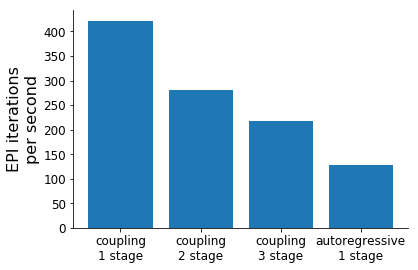

In [19]:
num_iters = opt_data_ar['iteration'].max()
times = timing_coups + [timing_ar]
time_per_it = [num_iters / time for time in times]
labels = ['coupling\n%d stage' % d for d in range(1, 4)] + ['autoregressive\n1 stage']
plt.figure()
ax = plt.gca()
ax.bar(x, time_per_it)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('EPI iterations\nper second')


We can get an idea of the expressivity of the normalizing flow architectures by looking at whether or not they were able to satisfy the constraints.  We see that the only architecture unable to converge (right panel below) was the coupling architecture with only 1 stage. It makes sense that only parameterizing $p(a_{21}, a_{22} \mid a_{11}, a_{12})$ is far too limiting.

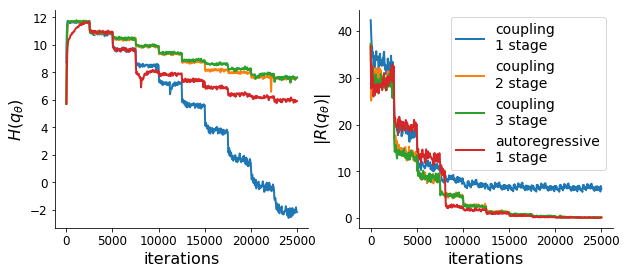

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i in range(len(num_stages)):
    Rs = opt_data_coups[i][['R%d' % j for j in range(1, M.m+1)]].to_numpy()
    R_norm = np.linalg.norm(Rs, axis=1)
    
    axs[0].plot(opt_data_coups[i]['iteration'], opt_data_coups[i]['H'])
    axs[1].plot(opt_data_coups[i]['iteration'], R_norm)

Rs_ar = opt_data_ar[['R%d' % j for j in range(1, M.m+1)]].to_numpy()
R_norm_ar = np.linalg.norm(Rs_ar, axis=1)

axs[0].plot(opt_data_ar['iteration'], opt_data_ar['H'])
axs[1].plot(opt_data_ar['iteration'], R_norm_ar)

axs[0].set_xlabel('iterations')
axs[0].set_ylabel(r'$H(q_\theta)$')
axs[1].set_xlabel('iterations')
axs[1].set_ylabel(r'$|R(q_\theta)|$')
axs[1].legend(labels)
plt.show()

We also notice from the entropy plot (left above) that the autoregressive normalizing flow converged with lower entropy than the coupling architectures with additional stages.  This would make us suspect that if the multi-stage coupling normalizing flows are capturing the true bi-modal parameter distribution, the autoregressive distribution is converging to a single mode. This is precisely what we see when plotting the optimized distributions for each architecture below.

### Coupling architecture with 1 stage (no convergence).

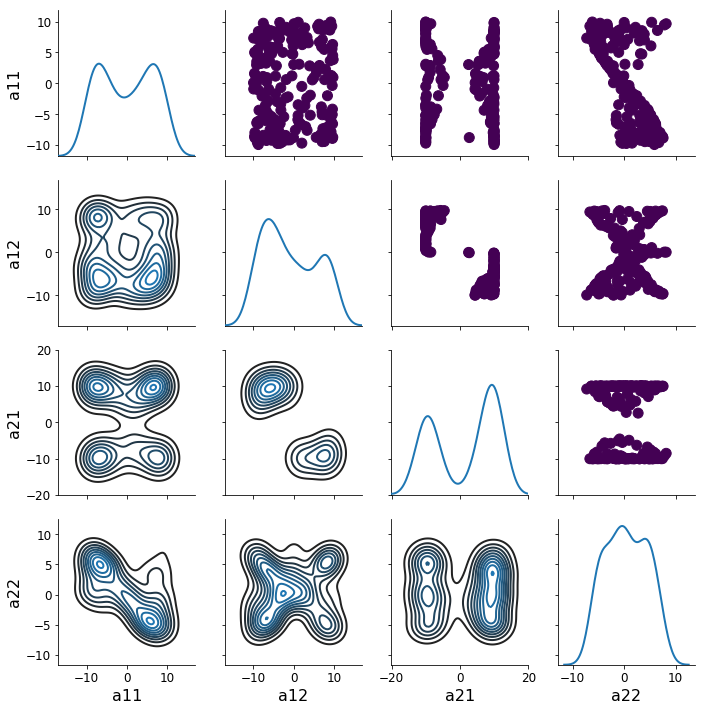

In [23]:
q_theta_coups[0].plot_dist()

### Coupling architecture with 2 stages (convergence).

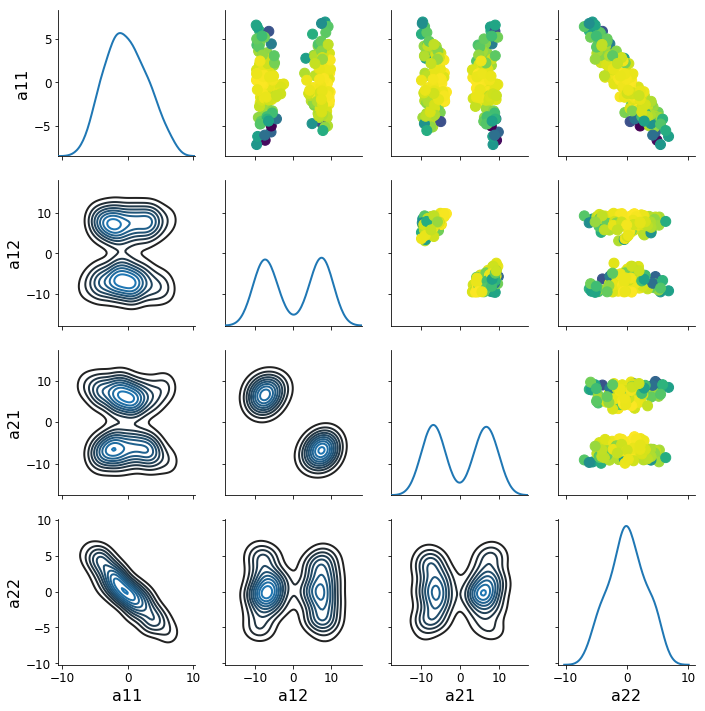

In [24]:
q_theta_coups[1].plot_dist()

### Coupling architecture with 3 stages (convergence).

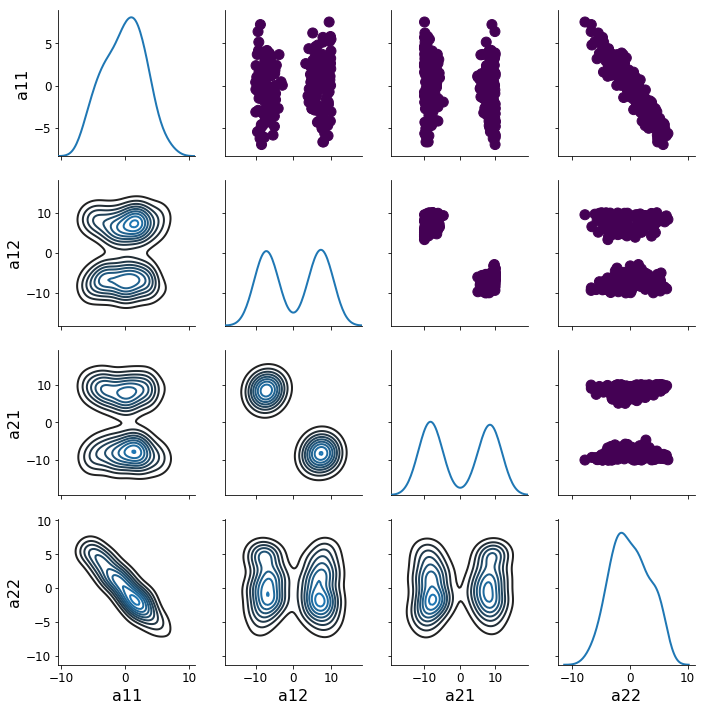

In [25]:
q_theta_coups[2].plot_dist()

### Autoregressive architecture with 1 stage (convergence at low entropy).

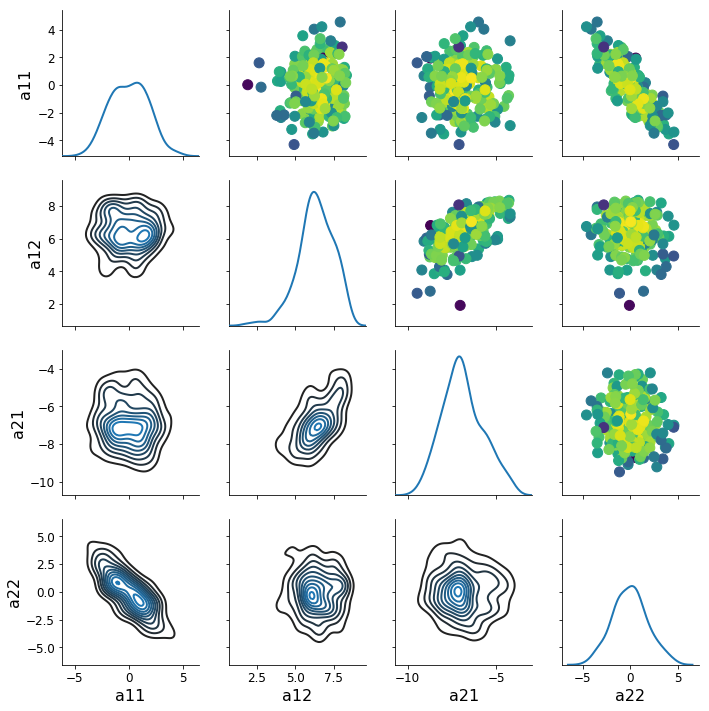

In [7]:
q_theta_ar.plot_dist()